In [1]:
# Binary Classification with Sonar Dataset: Baseline
from pandas import read_csv, read_pickle
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Concatenate, Input, Dense, Embedding, Flatten, Dropout, BatchNormalization, SpatialDropout1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import  Adam
import tensorflow.keras.backend as k
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import tensorflow as tf
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def strLower(s):
    return str(s).lower()

In [3]:
# load dataset
train = read_pickle("input/train_prepared.pickle")
test = read_pickle("input/test_prepared.pickle")
sample_submission = read_csv('./input/sample_submission.csv', index_col='TransactionID')
features = read_csv("input/feature_importances0.csv", index_col = 0)

In [4]:
train=train.sort_values(by=['TransactionID'])
train=train.set_index('TransactionID')
train=train.drop(['TransactionDT'],axis=1)
train=train.drop(['Unnamed: 0'],axis=1)

test=test.sort_values(by=['TransactionID'])
test=test.set_index('TransactionID')
test=test.drop(['TransactionDT'],axis=1)
test=test.drop(['Unnamed: 0'],axis=1)

In [5]:
#count the number of nulls per row
train['numNaN']=train.isna().sum(axis=1)
test['numNaN']=test.isna().sum(axis=1)

In [6]:
#change all strings in columns to lowercase
for i in range(len(train.dtypes.values)):
    if "object" in str(train.dtypes.values[i]):
        col = train.columns[i]
        train[col]=train[col].apply(strLower)
        test[col]=test[col].apply(strLower)

In [7]:
#train=train.drop(['ProductCD', 'addr1', 'M2'],axis=1)
#test=test.drop(['ProductCD', 'addr1', 'M2'],axis=1)

#categorise each column into either continuous or discrete
######browser + browser version tgt and OS and OS version
continuous = ['TransactionAmt','dist1','numNaN'] + list(train.filter(regex='^C[0-9]')) + list(train.filter(regex='^D[0-9]')) + list(train.filter(regex='^V'))
discrete = ['ProductCD','addr1','addr2','P_emaildomain','R_emaildomain',
            'DeviceType', 'DeviceInfo', 'OS_id_30', 'version_id_30', 'browser',
 'b_version',] + list(train.filter(regex='^card')) + list(train.filter(regex='^M')) + list(train.filter(regex='^id_'))

top_50 = ['card1', 'card2', 'addr1', 'TransactionAmt', 'D15', 'dist1', 'D4', 'D2', 'D10', 'card5', 'D11', 'C13', 'D1', 'id_02', 'P_emaildomain', 'D5', 'id_20', 'D3', 'id_19', 'C1', 'D8', 'C2', 'b_version', 'V307', 'V310', 'C14', 'C6', 'C11', 'V313', 'C9', 'V127', 'id_13', 'V130', 'D9', 'id_06', 'V315', 'V314', 'M4', 'V308', 'R_emaildomain', 'DeviceInfo', 'id_05', 'M5', 'V312', 'C5', 'card4', 'id_33', 'id_01', 'M6', 'V317']

dropped = ['TransactionAmt', 'dist1', 'C1', 'C5', 'C7', 'C9', 'C13', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V13', 'V15', 'V17', 'V19', 'V20', 'V29', 'V31', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V44', 'V45', 'V46', 'V47', 'V48', 'V50', 'V51', 'V53', 'V54', 'V56', 'V57', 'V59', 'V61', 'V62', 'V63', 'V64', 'V69', 'V71', 'V73', 'V75', 'V76', 'V78', 'V79', 'V80', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V92', 'V95', 'V96', 'V99', 'V100', 'V130', 'V131', 'V138', 'V139', 'V140', 'V141', 'V142', 'V144', 'V146', 'V147', 'V148', 'V151', 'V152', 'V157', 'V161', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V180', 'V181', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V194', 'V195', 'V197', 'V198', 'V200', 'V201', 'V205', 'V206', 'V208', 'V214', 'V217', 'V218', 'V220', 'V221', 'V223', 'V224', 'V226', 'V227', 'V228', 'V229', 'V230', 'V234', 'V235', 'V236', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243', 'V245', 'V246', 'V247', 'V248', 'V250', 'V252', 'V255', 'V257', 'V258', 'V260', 'V261', 'V262', 'V263', 'V266', 'V267', 'V270', 'V276', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V294', 'V302', 'V303', 'V310', 'V312', 'V313', 'V314', 'V325', 'V326', 'V327', 'V328', 'V329', 'V334']
lgbm_feature = list(features.feature)

continuous = [x for x in continuous if x in top_50]
discrete = [x for x in discrete if x in top_50]

In [8]:
discrete

['addr1',
 'P_emaildomain',
 'R_emaildomain',
 'DeviceInfo',
 'b_version',
 'card1',
 'card2',
 'card4',
 'card5',
 'M4',
 'M5',
 'M6',
 'id_01',
 'id_02',
 'id_05',
 'id_06',
 'id_13',
 'id_19',
 'id_20',
 'id_33']

In [9]:
%%time
#Fill nan with zeroes for NN for continuos values
#Fill nan with "other" for NN for discrete values
def fill_nan(df):
    for x in list(df.columns.values):
        if x in continuous:
            df[x] = df[x].fillna(0)
            
        elif x in discrete:
            df[x] = df[x].replace("nan", "other")
            df[x] = df[x].replace(np.nan, "other")
    return df

train=fill_nan(train)
test=fill_nan(test)

Wall time: 27.8 s


In [10]:
#Label encoding
label_counts = {}
for col in tqdm.tqdm(train.columns):
    if col in discrete:
        le = LabelEncoder()
        le.fit(list(train[col].values) + list(test[col].values))
        train[col] = le.transform(list(train[col].values))
        test[col] = le.transform(list(test[col].values))
        label_counts[col]=len(list(le.classes_)) + 1

100%|████████████████████████████████████████████████████████████████████████████████| 353/353 [00:30<00:00, 11.74it/s]


In [11]:
for col in continuous:
    scaler = StandardScaler()
    if train[col].max() > 100 and train[col].min() >= 0:
        train[col] = np.log1p(train[col])
        test[col] = np.log1p(test[col])
    scaler.fit(np.concatenate([train[col].values.reshape(-1,1), test[col].values.reshape(-1,1)]))
    train[col] = scaler.transform(train[col].values.reshape(-1,1))
    test[col] = scaler.transform(test[col].values.reshape(-1,1))

In [12]:
target = 'isFraud'

In [13]:
#split training set into training and validation set
train_set, valid_set = train_test_split(train, test_size = 0.2, random_state = 4041, shuffle = False)

In [14]:
#Convert each column in the discrete list into a tensor and append into a list
def create_model():
    k.clear_session()
    categorical_inputs = []
    for cat in discrete:
        categorical_inputs.append(Input(shape=[1], name=cat))

    #connect each embedding for each columns with their respective input
    categorical_embeddings = []
    for i, cat in enumerate(discrete):
        categorical_embeddings.append(
            Embedding(label_counts[cat], int(np.log1p(label_counts[cat]) + 1), name = cat + "_embed")(categorical_inputs[i]))

    categorical_logits = Concatenate(name = "categorical_conc")([Flatten()(SpatialDropout1D(.1)(cat_emb)) for cat_emb in categorical_embeddings])

    #Convert continuous columns into tensors
    numerical_inputs = Input(shape=[train[continuous].shape[1]], name = 'continuous')
    numerical_logits = Dropout(.1)(numerical_inputs)

    #Join in the 2 logits together to form 1 layer
    x = Concatenate()([categorical_logits, numerical_logits,])

    #Build the hidden layer and output to 1 node
    x = Dense(200, activation = 'relu')(x)
    x = Dropout(.2)(x)
    x = Dense(100, activation = 'relu')(x)
    x = Dropout(.2)(x)
    out = Dense(1, activation = 'sigmoid')(x)

    model = Model(inputs=categorical_inputs + [numerical_inputs],outputs=out)
    loss = "binary_crossentropy"
    model.compile(optimizer=Adam(lr = 0.01), loss = loss)
    return model

In [15]:
discrete_backup = deepcopy(discrete)
continuous_backup = deepcopy(continuous)

In [16]:
def get_input_features(df):
    X = {'continuous':np.array(df[continuous])}
    for cat in discrete:
        X[cat] = np.array(df[cat])
    return X

In [17]:
X_train = get_input_features(train_set)
X_valid = get_input_features(valid_set)
X_test = get_input_features(test)
y_train = train_set[target]
y_valid = valid_set[target]

model = create_model()

best_score = 0
patience = 0

for i in range(100):
    if patience < 3:
        hist = model.fit(X_train, y_train, validation_data = (X_valid,y_valid), batch_size = 8000, epochs = 1, verbose = 1)
        valid_preds = model.predict(X_valid, batch_size =  8000, verbose = True)
        score = roc_auc_score(y_valid, valid_preds)
        print(score)
        if score > best_score:
            model.save_weights("best_model.h5")
            best_score = score
            patience = 0
        else:
            patience += 1

Train on 472432 samples, validate on 118108 samples
118108/118108 [==============================] - 0s 3us/sample
0.8704764198018474
Train on 472432 samples, validate on 118108 samples
118108/118108 [==============================] - 0s 1us/sample
0.870434308560144
Train on 472432 samples, validate on 118108 samples
118108/118108 [==============================] - 0s 1us/sample
0.8493565041946097
Train on 472432 samples, validate on 118108 samples
118108/118108 [==============================] - 0s 1us/sample
0.8491084033355548


In [18]:
model = create_model()

In [19]:
model.load_weights("best_model.h5")

In [20]:
X_valid = get_input_features(valid_set)
X_test = get_input_features(test)
valid_preds = model.predict(X_valid, batch_size = 500, verbose = True)
score = roc_auc_score(y_valid, valid_preds)
print(score)

118108/118108 [==============================] - 2s 16us/sample
0.8704764154866185


In [21]:
hist = model.fit(X_valid,y_valid, batch_size = 8000, epochs = 3, verbose = 1)

Train on 118108 samples
Epoch 1/3
118108/118108 [==============================] - 4s 35us/sample - loss: 0.1044
Epoch 2/3
118108/118108 [==============================] - 1s 7us/sample - loss: 0.0858
Epoch 3/3
118108/118108 [==============================] - ETA: 0s - loss: 0.0723- ETA: 0s - lo - 1s 8us/sample - loss: 0.0720


In [22]:
predictions = model.predict(X_test, batch_size = 2000, verbose = True)

506691/506691 [==============================] - 2s 4us/sample


In [23]:
sample_submission[target] = predictions
sample_submission.to_csv('prediction.csv')

In [24]:
!kaggle competitions submit -c ieee-fraud-detection -f prediction.csv -m "Message"

Successfully submitted to IEEE-CIS Fraud Detection


  0%|          | 0.00/10.4M [00:00<?, ?B/s]
  7%|6         | 712k/10.4M [00:00<00:01, 7.08MB/s]
 22%|##2       | 2.30M/10.4M [00:00<00:01, 8.44MB/s]
 28%|##7       | 2.88M/10.4M [00:03<00:13, 592kB/s] 
 65%|######4   | 6.77M/10.4M [00:03<00:04, 841kB/s]
 96%|#########6| 10.0M/10.4M [00:03<00:00, 1.19MB/s]
100%|##########| 10.4M/10.4M [00:09<00:00, 1.10MB/s]


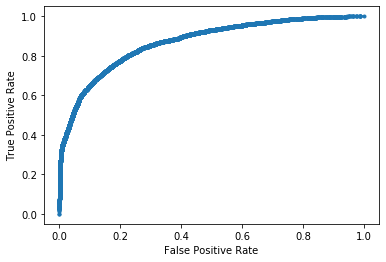

In [25]:
fpr, tpr, _ = roc_curve(y_valid, valid_preds)
plt.plot(fpr, tpr, marker='.', label='nn prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig("roc.png")

In [26]:
continuous


['TransactionAmt',
 'dist1',
 'C1',
 'C2',
 'C5',
 'C6',
 'C9',
 'C11',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D8',
 'D9',
 'D10',
 'D11',
 'D15',
 'V127',
 'V130',
 'V307',
 'V308',
 'V310',
 'V312',
 'V313',
 'V314',
 'V315',
 'V317']